# Personalized Recommendation System Using Deep Learning
# Deep Learning Final Project (MovieLens 32M)

## 1. Introduction

This notebook builds a personalized movie recommendation system using the MovieLens 32M dataset and deep learning models. We'll use Neural Collaborative Filtering (NCF) to predict user preferences.

## 2. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import tensorflow as tf

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
ratings_df =  pd.read_csv("/Users/chinguyen/Desktop/USF-MSDS/MSDS-634/final-project/data/ml-32m/ratings.csv")
links_df = pd.read_csv("/Users/chinguyen/Desktop/USF-MSDS/MSDS-634/final-project/data/ml-32m/links.csv")
movies_df = pd.read_csv("/Users/chinguyen/Desktop/USF-MSDS/MSDS-634/final-project/data/ml-32m/movies.csv")
tags_df = pd.read_csv("/Users/chinguyen/Desktop/USF-MSDS/MSDS-634/final-project/data/ml-32m/tags.csv")

In [4]:
print(ratings_df.shape)
print(links_df.shape)
print(movies_df.shape)
print(tags_df.shape)

(32000204, 4)
(87585, 3)
(87585, 3)
(2000072, 4)


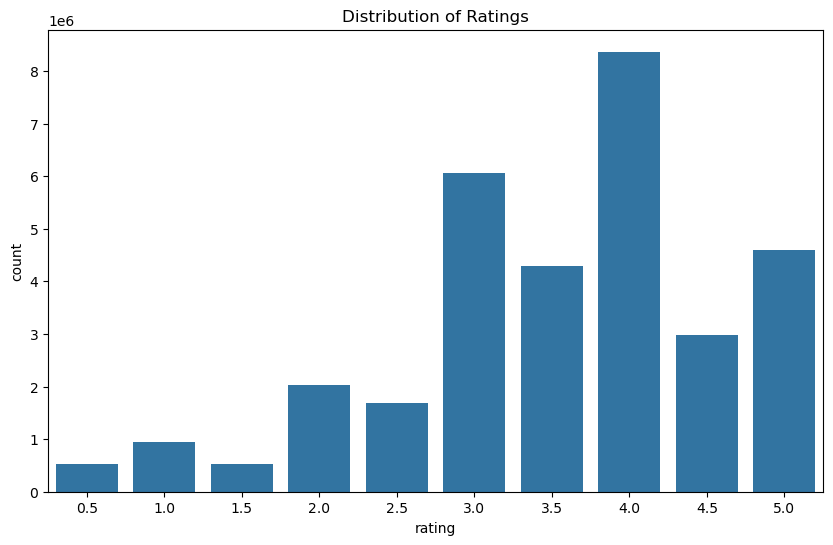

In [5]:
# Ratings distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.show()

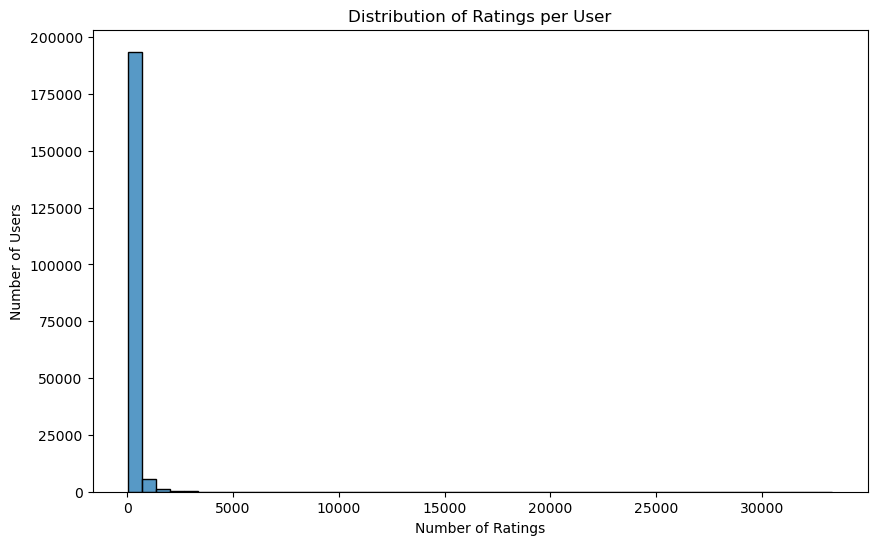

In [6]:
 # Users activity
user_activity = ratings_df['userId'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

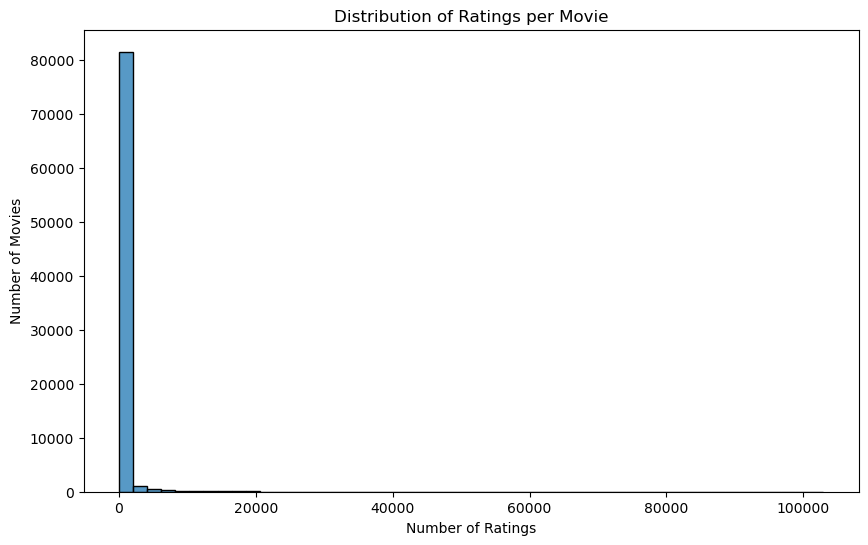

In [7]:
# Movie popularity
movie_popularity = ratings_df['movieId'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(movie_popularity, bins=50)
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

In [8]:
# Basic statistics
ratings_stats = {
    'Number of users': ratings_df['userId'].nunique(),
    'Number of movies': ratings_df['movieId'].nunique(),
    'Sparsity': (1 - len(ratings_df) / 
                (ratings_df['userId'].nunique() * ratings_df['movieId'].nunique())) * 100
}

print("\nDataset Statistics:")
for key, value in ratings_stats.items():
    if key == 'Sparsity':
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value}")


Dataset Statistics:
Number of users: 200948
Number of movies: 84432
Sparsity: 99.81%


In [9]:
# Filter users and movies with minimum ratings
user_counts = ratings_df['userId'].value_counts()
movie_counts = ratings_df['movieId'].value_counts()
min_user_ratings=60
min_movie_ratings=5
implicit_threshold=4.0
active_users = user_counts[user_counts >= min_user_ratings].index
popular_movies = movie_counts[movie_counts >= min_movie_ratings].index

In [10]:
filtered_df = ratings_df[ratings_df['userId'].isin(active_users) & 
                        ratings_df['movieId'].isin(popular_movies)]
print(f"Filtered data: {len(filtered_df)} ratings from {len(active_users)} users on {len(popular_movies)} movies")
        

Filtered data: 28866942 ratings from 114339 users on 43884 movies


In [11]:
# Convert timestamps to datetime and add features
filtered_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_df['timestamp'], unit='s')
filtered_df.loc[:, 'year'] = filtered_df['timestamp'].dt.year
filtered_df.loc[:, 'month'] = filtered_df['timestamp'].dt.month
filtered_df.loc[:, 'dayofweek'] = filtered_df['timestamp'].dt.dayofweek
# Sort by timestamp for temporal splitting
filtered_df = filtered_df.sort_values('timestamp')

/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_69113/781687869.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1999-12-03 19:24:37', '1999-12-03 19:43:48', '1999-11-22 00:36:16',
 '1999-12-03 19:24:37', '1999-11-22 00:00:58', '1999-11-21 23:54:51',
 '1999-12-03 19:23:28', '1999-12-03 19:22:23', '1999-11-22 00:38:39',
 '1999-12-03 19:23:28',
 ...
 '2012-10-16 21:43:12', '2012-10-16 21:44:49', '2012-10-16 21:43:42',
 '2010-10-16 10:04:58', '2011-01-07 15:03:50', '2011-01-07 15:03:09',
 '2010-10-16 08:04:52', '2011-01-07 15:04:31', '2012-10-16 21:43:20',
 '2012-10-16 21:38:43']
Length: 28866942, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_df['timestamp'], unit='s')
/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_69113/781687869.py:3: SettingWithCopyW

In [12]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
user_encoder.fit(filtered_df['userId'].unique())
movie_encoder.fit(filtered_df['movieId'].unique())
        

LabelEncoder()

In [13]:
filtered_df['user_idx'] = user_encoder.transform(filtered_df['userId'])
filtered_df['movie_idx'] = movie_encoder.transform(filtered_df['movieId'])

In [14]:
filtered_df['implicit'] = (filtered_df['rating'] >= implicit_threshold).astype(int)
processed_df = filtered_df.copy()

In [15]:
# Update movie dataframe to include only movies in the filtered dataset
movies_df = movies_df[movies_df['movieId'].isin(popular_movies)]

In [16]:
# Process genres into a binary matrix
genres = movies_df['genres'].str.split('|').explode().unique()
for genre in genres:
    if genre != '(no genres listed)':
        movies_df[f'genre_{genre}'] = movies_df['genres'].str.contains(genre).astype(int)

In [34]:
movie_features = movies_df.filter(regex='^genre_').values

In [35]:
# Map movie_idx to genre features
movie_id_to_genre = dict(zip(movies_df['movieId'], movie_features))
movie_idx_to_genre = {movie_encoder.transform([mid])[0]: vec for mid, vec in movie_id_to_genre.items()}

In [17]:
# Split the data into training, validation and test sets
# Temporal splitting - last interactions for each user go to test
val_size=0.1
test_size=0.1
test_ratings = []
val_ratings = []
train_ratings = []
for user_id, group in processed_df.groupby('user_idx'):
        # Sort by timestamp
    group = group.sort_values('timestamp')
    n_ratings = len(group)
        
    # Calculate split indices
    test_idx = int(n_ratings * (1 - test_size))
    val_idx = int(n_ratings * (1 - test_size - val_size))
        
    # Split the user's ratings
    test_ratings.append(group.iloc[test_idx:])
    val_ratings.append(group.iloc[val_idx:test_idx])
    train_ratings.append(group.iloc[:val_idx])
    
# Combine the splits
test_df = pd.concat(test_ratings).reset_index(drop=True)
val_df = pd.concat(val_ratings).reset_index(drop=True)
train_df = pd.concat(train_ratings).reset_index(drop=True)
    
print(f"Train set: {len(train_df)} interactions")
print(f"Validation set: {len(val_df)} interactions")
print(f"Test set: {len(test_df)} interactions")
    

Train set: 23048142 interactions
Validation set: 2880460 interactions
Test set: 2938340 interactions


In [18]:
def _sample_negatives(df, neg_ratio):
        """
        Sample negative interactions for each user
        
        Args:
            df: DataFrame with user-item interactions
            neg_ratio: Ratio of negative to positive samples
        """
        all_movies = set(range(len(movie_encoder.classes_)))
        negatives = []
        
        for user_id, group in df.groupby('user_idx'):
            # Get positive items for this user
            pos_items = set(group['movie_idx'])
            
            # Calculate available negative items
            neg_items = list(all_movies - pos_items)
            
            # Sample negative items
            neg_count = min(len(neg_items), len(group) * neg_ratio)
            if neg_count > 0:
                sampled_negs = np.random.choice(neg_items, size=neg_count, replace=False)
                
                # Create negative samples
                user_negs = pd.DataFrame({
                    'user_idx': [user_id] * neg_count,
                    'movie_idx': sampled_negs,
                    'implicit': [0] * neg_count
                })
                
                negatives.append(user_negs)
        
        if negatives:
            return pd.concat(negatives)
        else:
            return pd.DataFrame(columns=['user_idx', 'movie_idx', 'implicit'])

In [19]:

# Generate negative samples for training
neg_ratio=4
train_negatives = _sample_negatives(train_df, neg_ratio)
val_negatives = _sample_negatives(val_df, neg_ratio)
test_negatives = _sample_negatives(test_df, neg_ratio)

# Combine positive and negative samples
train_data = pd.concat([
train_df[['user_idx', 'movie_idx', 'implicit']],
            train_negatives
        ]).reset_index(drop=True)
        
val_data = pd.concat([
val_df[['user_idx', 'movie_idx', 'implicit']],
            val_negatives
        ]).reset_index(drop=True)
        
test_data = pd.concat([
test_df[['user_idx', 'movie_idx', 'implicit']],
            test_negatives
        ]).reset_index(drop=True)

In [20]:
print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")  
print(f"Test data: {len(test_data)} samples")

Training data: 115182029 samples
Validation data: 14402300 samples
Test data: 14691700 samples


In [21]:
# Prepare user and item feature matrices for hybrid models
# User features (could be expanded with demographic data if available)
n_users = len(user_encoder.classes_)
# Create user feature matrix (currently just one-hot encoding)
user_features = np.eye(n_users)
# Item features based on genres
movie_features = movies_df.filter(regex='^genre_').values

In [22]:
print(f"User features shape: {user_features.shape}")
print(f"Movie features shape: {movie_features.shape}")

User features shape: (114339, 114339)
Movie features shape: (43884, 19)


## Prepare Dataset for Model

In [ ]:
from tensorflow.keras.utils import Sequence

class NCFDataGenerator(Sequence):
    def __init__(self, df, batch_size):
        self.users = df['user_idx'].values
        self.items = df['movie_idx'].values
        self.labels = df['implicit'].values
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.users) / self.batch_size))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        return (
            {
                "user_input": self.users[start:end],
                "item_input": self.items[start:end]
            },
            self.labels[start:end]
        )

## Build the NCF Model

In [24]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

def build_ncf_model(num_users, num_items, embedding_dim=64):
    user_input = Input(shape=(1,), name="user_input")
    item_input = Input(shape=(1,), name="item_input")

    user_emb = Embedding(num_users, embedding_dim, name="user_embedding")(user_input)
    item_emb = Embedding(num_items, embedding_dim, name="item_embedding")(item_input)

    # Flatten and concatenate
    user_vec = Flatten()(user_emb)
    item_vec = Flatten()(item_emb)
    concat = Concatenate()([user_vec, item_vec])

    # MLP layers
    x = Dense(128, activation='relu')(concat)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


## Train the Model

In [25]:
batch_size = 1024
train_gen = NCFDataGenerator(train_data, batch_size)
val_gen = NCFDataGenerator(val_data, batch_size)

n_users = len(user_encoder.classes_)
n_items = len(movie_encoder.classes_)

ncf_model = build_ncf_model(n_users, n_items)
ncf_model.summary()

# Train
ncf_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 64)     │  7,317,696 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 64)     │  2,808,576 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,153,153 (38.73 MB)

 Trainable params: 10,153,153 (38.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/opt/homebrew/anaconda3/envs/MSDS/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112483/112483 ━━━━━━━━━━━━━━━━━━━━ 2287s 20ms/step - accuracy: 0.9174 - loss: 0.1802 - val_accuracy: 0.9193 - val_loss: 0.1822
Epoch 2/5
112483/112483 ━━━━━━━━━━━━━━━━━━━━ 1893s 17ms/step - accuracy: 0.9221 - loss: 0.1706 - val_accuracy: 0.9221 - val_loss: 0.1803
Epoch 3/5
112483/112483 ━━━━━━━━━━━━━━━━━━━━ 5558s 49ms/step - accuracy: 0.9259 - loss: 0.1646 - val_accuracy: 0.9245 - val_loss: 0.1739
Epoch 4/5
112483/112483 ━━━━━━━━━━━━━━━━━━━━ 1961s 17ms/step - accuracy: 0.9279 - loss: 0.1604 - val_accuracy: 0.9257 - val_loss: 0.1715
Epoch 5/5
112483/112483 ━━━━━━━━━━━━━━━━━━━━ 1780s 16ms/step - accuracy: 0.9298 - loss: 0.1565 - val_accuracy: 0.9267 - val_loss: 0.1679


## Model evaluation

In [26]:
from tqdm import tqdm
from sklearn.metrics import ndcg_score

def evaluate_model(model, test_df, k=10):
    grouped = test_df.groupby("user_idx")
    
    precision_list = []
    recall_list = []
    hitrate_list = []
    ndcg_list = []

    for user_id, group in tqdm(grouped):
        # True labels
        y_true = group.sort_values("movie_idx")["implicit"].values
        
        # Predict scores
        user_input = np.full(len(group), user_id)
        item_input = group["movie_idx"].values
        y_score = model.predict({"user_input": user_input, "item_input": item_input}, verbose=0).flatten()
        
        # Rank predictions
        top_k_idx = np.argsort(-y_score)[:k]
        top_k_labels = y_true[top_k_idx]

        # Precision@K
        precision = np.mean(top_k_labels)
        precision_list.append(precision)

        # Recall@K
        total_positives = np.sum(y_true)
        recall = np.sum(top_k_labels) / total_positives if total_positives > 0 else 0
        recall_list.append(recall)

        # HitRate@K
        hitrate = 1.0 if np.sum(top_k_labels) > 0 else 0.0
        hitrate_list.append(hitrate)

        # NDCG@K
        ndcg = ndcg_score([y_true], [y_score], k=k)
        ndcg_list.append(ndcg)

    results = {
        "Precision@K": np.mean(precision_list),
        "Recall@K": np.mean(recall_list),
        "HitRate@K": np.mean(hitrate_list),
        "NDCG@K": np.mean(ndcg_list),
    }

    return results


In [27]:
results_at_10 = evaluate_model(ncf_model, test_data, k=10)
print("\n📈 Evaluation Results @10:")
for metric, score in results_at_10.items():
    print(f"{metric}: {score:.4f}")

100%|██████████| 114339/114339 [4:41:41<00:00,  6.77it/s]     



📈 Evaluation Results @10:
Precision@K: 0.2504
Recall@K: 0.3294
HitRate@K: 0.8259
NDCG@K: 0.3190


In [28]:
import numpy as np
from sklearn.metrics import ndcg_score
from tqdm import tqdm

def evaluate_model_fast(model, test_df, all_items, k=10, num_negative=100):
    precision_list, recall_list, hitrate_list, ndcg_list = [], [], [], []

    grouped = test_df.groupby("user_idx")

    for user_id, group in tqdm(grouped, desc="Evaluating"):
        pos_items = group[group["implicit"] == 1]["movie_idx"].tolist()

        if not pos_items:
            continue  # skip users with no positives

        for true_item in pos_items:
            # Sample negatives
            negatives = list(set(all_items) - set([true_item]))
            neg_sample = np.random.choice(negatives, size=num_negative, replace=False)

            item_input = np.array([true_item] + neg_sample)
            user_input = np.full_like(item_input, fill_value=user_id)

            # Predict scores for true + negatives
            y_score = model.predict({"user_input": user_input, "item_input": item_input}, verbose=0).flatten()

            # Rank scores
            top_k_idx = np.argsort(-y_score)[:k]
            top_k_items = item_input[top_k_idx]

            # Binary relevance labels
            y_true = np.zeros_like(item_input)
            y_true[0] = 1  # first is always true item

            # Top-K labels
            top_k_labels = y_true[top_k_idx]

            # Metrics
            precision_list.append(np.mean(top_k_labels))
            recall_list.append(np.sum(top_k_labels))
            hitrate_list.append(1.0 if np.sum(top_k_labels) > 0 else 0.0)
            ndcg_list.append(ndcg_score([y_true], [y_score], k=k))

    return {
        "Precision@K": np.mean(precision_list),
        "Recall@K": np.mean(recall_list),
        "HitRate@K": np.mean(hitrate_list),
        "NDCG@K": np.mean(ndcg_list),
    }


In [29]:
def evaluate_and_store(model, model_name, test_data, k, results_dict):
    metrics = evaluate_model(model, test_data, k)
    results_dict[model_name] = {
        f"Precision@{k}": metrics["Precision@K"],
        f"Recall@{k}": metrics["Recall@K"],
        f"HitRate@{k}": metrics["HitRate@K"],
        f"NDCG@{k}": metrics["NDCG@K"]
    }
    print(f"{model_name} done.")


In [30]:
model_scores = {}
k = 10
# Evaluate NCF model
evaluate_and_store(ncf_model, "NCF", test_data, k, model_scores)

100%|██████████| 114339/114339 [1:27:54<00:00, 21.68it/s]   


NCF done.


In [ ]:
# When other models are ready, just call:
# evaluate_and_store(deepfm_model, "DeepFM", test_data, k, model_scores)
# evaluate_and_store(hybrid_model, "HybridNCF", test_data, k, model_scores)
# evaluate_and_store(transformer_model, "TransformerRec", test_data, k, model_scores)

In [31]:
def plot_model_comparison(scores_dict, k):
    df_scores = pd.DataFrame(scores_dict).T  # models as rows

    plt.figure(figsize=(12, 6))
    df_scores.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title(f'Model Performance Comparison @{k}', fontsize=16)
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.ylim(0, 1.0)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [33]:
model_scores

{'NCF': {'Precision@10': 0.25040449890238675,
  'Recall@10': 0.32939836709895737,
  'HitRate@10': 0.8259211642571651,
  'NDCG@10': 0.31899022601921057}}

<Figure size 1200x600 with 0 Axes>

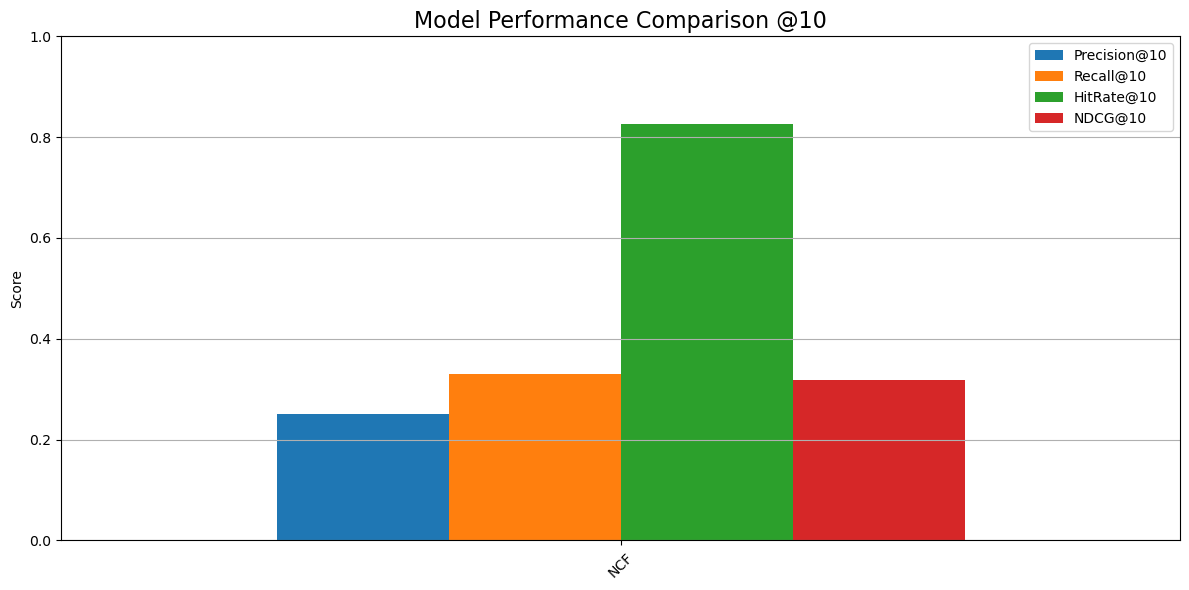

In [32]:
plot_model_comparison(model_scores, k=10)
